## ※ Business analytics tutorial- Ensemble learning
---
본 튜토리얼은 고려대학교 강필성 교수님의 Business analytics 수업의 내용을 정리한 튜토리얼 코드 입니다.  
튜토리얼에서는 Ensemble learning의 대표적인 방법론인 **XGBoost** 에 대한 코드와 간단한 설명을 다룹니다.  

출처1: https://www.kaggle.com/code/lifesailor/xgboost

In [1]:
!pip install xgboost

     |████████████████████████████████| 193.6 MB 53.9 MB/s eta 0:00:01


In [2]:
# library 호출
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

### loan_data를 활용한 실습 XGBoost 실습
본 실험에서는 대출 연체 여부를 예측하기 위해 구성된 데이터셋인 loan_data를 활용하여 실습을 진행합니다.  
각 변수에 대한 설명은 다음과 같습니다.  
  
<img src="images/loan_data_description.png" width="750px" height="777px" title="loan_data"/>  

본 데이터셋을 활용하여 XGBoost를 통해 성능을 평가하도록 하겠습니다.

In [3]:
# load loan data
loan_data = pd.read_csv('dataset/loan_data.csv')

In [4]:
loan_data.head()

,AGE,TOT_LOAN,TOT_LOAN_CRD,LOAN_BNK,LOAN_CPT,CRDT_CNT,GUARN_CNT,INCOME,LOAN_CRD_CNT,LATE_RATE,...,CALL_TIME,TEL_COST_MON,MOBILE_PRICE,SUSP_DAY,LATE_TEL,COMB_COMM,SEX,PAY_METHOD,JOB,TARGET
0,40,6,6,6,0,0,0,4500,0,16,...,1.52,120,500,0,120,0,M,A,A,0
1,35,9,9,0,0,1,0,3700,0,9,...,2.14,100,800,0,0,0,M,C,B,0
2,55,9,9,0,0,0,0,6400,0,1,...,0.50,50,700,0,0,0,M,C,B,0
3,55,42,0,42,0,5,0,8900,0,13,...,2.61,80,900,0,0,0,M,B,C,0
4,40,36,36,36,0,3,1,0,0,2,...,2.11,10,900,0,0,1,F,B,B,0


In [5]:
# 결측치 확인 -> 결측치가 없으므로 바로 사용

print(loan_data.isnull().sum())

AGE              0
TOT_LOAN         0
TOT_LOAN_CRD     0
LOAN_BNK         0
LOAN_CPT         0
CRDT_CNT         0
GUARN_CNT        0
INCOME           0
LOAN_CRD_CNT     0
LATE_RATE        0
LATE_RATE_1Y     0
INS_MON_MAX      0
CANCEL_CNT_1Y    0
CALL_TIME        0
TEL_COST_MON     0
MOBILE_PRICE     0
SUSP_DAY         0
LATE_TEL         0
COMB_COMM        0
SEX              0
PAY_METHOD       0
JOB              0
TARGET           0
dtype: int64


In [6]:
# 명목형 변수 one-hot encoding
loan_data_one_hot = pd.get_dummies(loan_data, columns=['SEX', 'PAY_METHOD', 'JOB'])

In [7]:
loan_data_one_hot.head()

,AGE,TOT_LOAN,TOT_LOAN_CRD,LOAN_BNK,LOAN_CPT,CRDT_CNT,GUARN_CNT,INCOME,LOAN_CRD_CNT,LATE_RATE,...,SEX_F,SEX_M,PAY_METHOD_A,PAY_METHOD_B,PAY_METHOD_C,PAY_METHOD_D,JOB_A,JOB_B,JOB_C,JOB_D
0,40,6,6,6,0,0,0,4500,0,16,...,0,1,1,0,0,0,1,0,0,0
1,35,9,9,0,0,1,0,3700,0,9,...,0,1,0,0,1,0,0,1,0,0
2,55,9,9,0,0,0,0,6400,0,1,...,0,1,0,0,1,0,0,1,0,0
3,55,42,0,42,0,5,0,8900,0,13,...,0,1,0,1,0,0,0,0,1,0
4,40,36,36,36,0,3,1,0,0,2,...,1,0,0,1,0,0,0,1,0,0


In [8]:
# 연속형 변수 normalization -> Standard scaler를 활용하여 normalization 진행

continuous_variable = ['AGE', 'TOT_LOAN', 'TOT_LOAN_CRD', 'LOAN_BNK', 'LOAN_CPT', 
'CRDT_CNT','GUARN_CNT', 'INCOME', 'LOAN_CRD_CNT', 'LATE_RATE', 'LATE_RATE_1Y',
'INS_MON_MAX', 'CANCEL_CNT_1Y', 'CALL_TIME', 'TEL_COST_MON','MOBILE_PRICE', 
'SUSP_DAY', 'LATE_TEL']

loan_data_continuos = loan_data_one_hot[continuous_variable]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(loan_data_continuos)
loan_data_continuos_scaled = scaler.transform(loan_data_continuos)

#scale 연속형 변수 dataframe화
dataframe_continuous = pd.DataFrame(loan_data_continuos_scaled,
 columns= continuous_variable)

# scale 연속형 변수와 명목형 변수 합치기
dataframe_scaled = pd.concat([dataframe_continuous, loan_data_one_hot.drop(columns=continuous_variable)], axis =1)

### XGBoost hyperparameter 탐색  
**XGBoost**는 매우 다양한 종류의 hyperparameter를 갖고 있습니다. 크게 **General parmeter, Boost Parameter, Learning Task Parameter** 3가지로 XGBoost의 하이퍼파라미터를 분류할 수 있습니다. 각각에 대한 설명과 각 하이퍼파라미터 군집에 구체적으로 어떠한 하이퍼파라미터가 있는지에 대한 설명은 아래와 같습니다.

- **General parmeter**: 전체적인 기능에 대한 가이드를 주는 하이퍼파라미터

    <img src="images/general_para.png" width="765px" height="169px" title="general_para">  
      

- **Boost Parameter**: 모델 성능에 가장 큰 영향을 주는 하이퍼파라미터로 모델의 과적합 등의 이슈 발생시 조절하는 하이퍼파라미터
  
    <img src="images/boost_para.png" width="765px" height="576px" title="boost_para">  
      
  
- **train Parameter**: 학습에 활용되는 objective function, eval metric등을 포함하는 하이퍼파라미터  
  
    <img src="images/train_para.png" width="765px" height="125px" title="train_para">  


위에서 설명한 hyperparameter들에 대하여 kfold validation을 통해 최적의 hyperparameter 조합을 찾고 성능을 산출합니다.


### Optuna를 활용한 XGBoost hyperparameter 탐색  
**XGBoost**는 위에서 언급한 것과 같이 매우 다양한 종류의 하이퍼파라미터를 갖습니다. 따라서 모든 하이퍼파라미터에 대해 최적화를 진행하는 것은 굉장히 많은 시간과 노력이 필요하면 이는 비효율적입니다. 본 튜토리얼에서는 **optuna** 라는 라이브러리를 활용하여 효율적인 하이퍼파라미터 탐색을 진행하고자 합니다. optuna는 하이퍼파라미터 탐색에 가장 많이 사용되는 라이브러리 중 하나로 지정한 범위 내의 하이퍼파라미터를 바탕으로 효율적인 탐색을 가능하도록 구현되어 있습니다. 또한 다양한 시각화 기능이 있는점도 매우 유용합니다. 본 튜토리얼에서는 optuna를 활용하여 하이퍼파라미터 탐색을 진행하겠습니다.

In [9]:
# train dataset, test dataset 분리
from sklearn.model_selection import train_test_split
test_size = 0.2
test_num = int(dataframe_scaled.shape[0] * test_size)
train_num = dataframe_scaled.shape[0] - test_num
train_idx = np.random.choice(dataframe_scaled.shape[0], train_num, replace=False)
test_idx = np.setdiff1d(range(dataframe_scaled.shape[0]), train_idx)

train_dataset = dataframe_scaled.iloc[train_idx]
test_dataset = dataframe_scaled.iloc[test_idx]

In [10]:
len(train_dataset) , len(test_dataset)

(34709, 8677)

In [11]:
# target 설정
X=train_dataset.drop('TARGET',axis=1)
y=train_dataset['TARGET']

In [12]:
import warnings
warnings.filterwarnings(action='ignore') 

In [13]:
# optuna 설정
from sklearn.metrics import log_loss

def objective(trial,train=train_dataset,target=y):

  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

  param={
      'max_depth':trial.suggest_int('max_depth',5,20),
      'learning_rate':trial.suggest_uniform('learning_rate',0.0001,0.99),
      'subsample':trial.suggest_discrete_uniform('subsample', 0.6,1.0,0.1),
      'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.3,0.9,0.1),
      'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, 100),
      'eval_metric': 'logloss',
      'objective' : 'binary:logistic',
      'random_state': 2,
      'n_estimators': 1000
  }

  model=XGBClassifier(**param)

  bst = model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=False)

  predictions=bst.predict_proba(X_test)

  logloss = log_loss(y_test,predictions)
  return logloss

In [14]:
import optuna

In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
study.best_params

[I 2022-11-29 02:38:55,084] A new study created in memory with name: no-name-f5e33b7d-ba82-4056-997d-de23a4f8566e
[I 2022-11-29 02:41:32,987] Trial 0 finished with value: 0.3142680193171218 and parameters: {'max_depth': 13, 'learning_rate': 0.19995021815553893, 'subsample': 0.9, 'colsample_bytree': 0.8, 'n_estimators': 1600}. Best is trial 0 with value: 0.3142680193171218.
[I 2022-11-29 02:44:49,688] Trial 1 finished with value: 0.34318947925856563 and parameters: {'max_depth': 19, 'learning_rate': 0.3697700761020934, 'subsample': 1.0, 'colsample_bytree': 0.7, 'n_estimators': 7700}. Best is trial 0 with value: 0.3142680193171218.
[I 2022-11-29 02:48:05,980] Trial 2 finished with value: 0.30164600940558295 and parameters: {'max_depth': 13, 'learning_rate': 0.16240788742073617, 'subsample': 0.7, 'colsample_bytree': 0.8, 'n_estimators': 5600}. Best is trial 2 with value: 0.30164600940558295.
[I 2022-11-29 02:49:46,055] Trial 3 finished with value: 0.41740286794344506 and parameters: {'max

{'max_depth': 17,
 'learning_rate': 0.005347693647565231,
 'subsample': 0.6,
 'colsample_bytree': 0.6000000000000001,
 'n_estimators': 7200}

In [21]:
# Accuracy 함수 구현
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):
    # make predictions
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluations
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %.2f%%' % (accuracy * 100.0))
    return accuracy

In [22]:
# target 설정
X_test=test_dataset.drop('TARGET',axis=1)
y_test=test_dataset['TARGET']

In [23]:
# test 진행
model=XGBClassifier(**study.best_params)
model.fit(X,y)
# print(model.evals_result)
calculate_accuracy(model, X_test, y_test)

Accuracy: 92.36%


0.9235911029157543

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [27]:
y_pred = model.predict_proba(X_test)[:,1]

In [31]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)


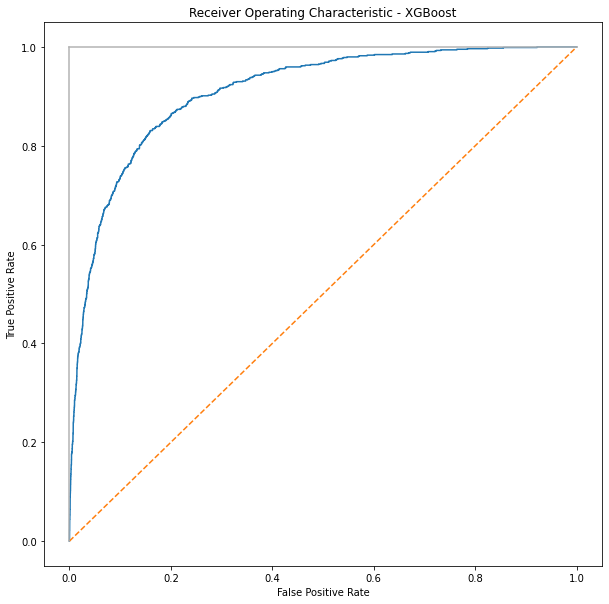

roc_auc_score for XGBoost:  0.9089308801198039


In [34]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('roc_auc_score for XGBoost: ', roc_auc_score(y_test, y_pred))

# 실험결과

optuna library를 활용하여 max_depth, learning_rate, subsample, colsample_bytree, n_estimators에 대한 최적화를 진행하였습니다. 각각의 하이퍼파라미터에 대한 최적화 결과는 {'max_depth': 17, 'learning_rate': 0.005347693647565231,
'subsample': 0.6, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 7200} 입니다. 해당 하이퍼파라미터 집합을 통해 test result를 산출한 결과 92.36%의 정확도를 달성하였습니다. 또한 AUC score 역시 0.91을 기록하여 상당히 높은 값을 산출한 것을 알 수 있었습니다. 즉 주어진 loan dataset은 XGBoost가 굉장히 높은 수준의 예측을 진행하고 있음을 알 수 있었습니다.  
이러한 XGBoost의 가장 큰 장점 중 하나는 XAI 즉 어떤 부분으로 인해 model이 이러한 결과를 산출했는지에 대한 시각적인 지표를 제공한다는 점 입니다.  
XGBoost가 제공하는 feature importance, shaply 변수를 통해 사후분석을 진행하도록 하겠습니다.  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

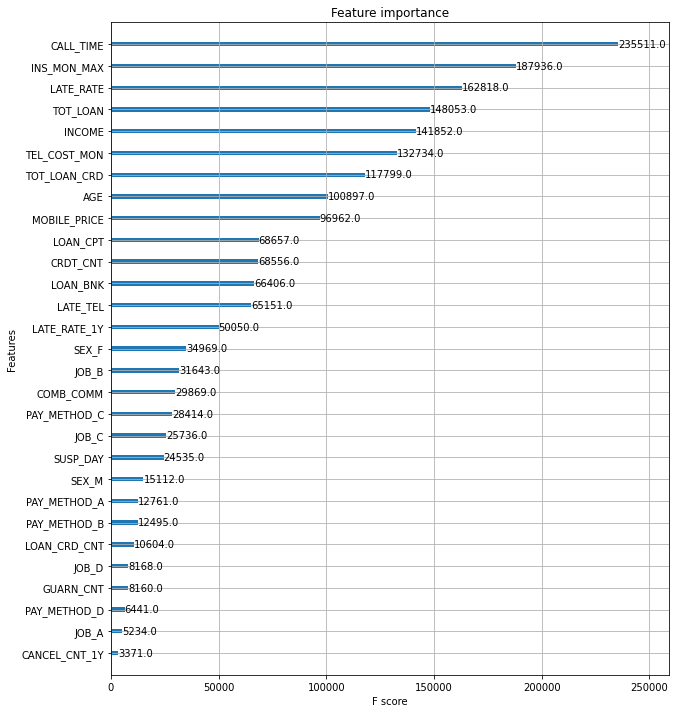

In [35]:
from xgboost import plot_importance
fig, ax=plt.subplots(figsize=(10,12))
plot_importance(model, ax=ax)

### Feature importance 분석
Feature importance 산출 결과 CALL_TIME(월별 통화시간), INS_MON_MAX(월납입보험료), LATE_RATE(보험료 연체율)이 높은 importance를 기록하였습니다. 다만 XGBoost에서 제공하는 feature importance의 경우 각 feature가 양의 방향으로 영향을 주었는지, 음의 방향으로 영향을 주었는지에 대한 부분은 정보를 제공하지 못합니다. 이러한 부분을 보완할 수 있는 shaply 지표를 통해 해당 내용에 대한 분석을 진행하고자 합니다.

In [36]:
!pip install shap

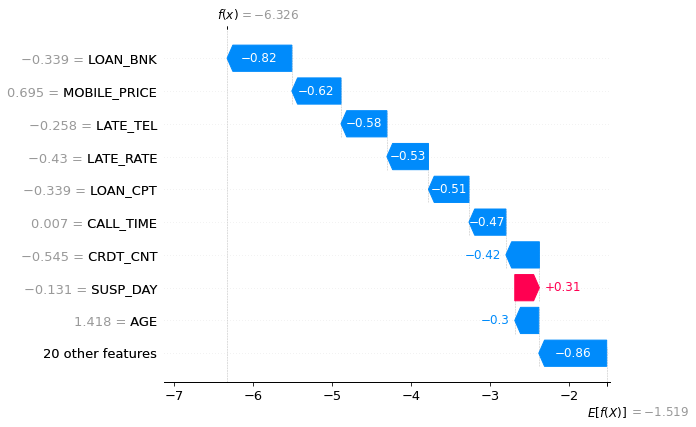

In [38]:
# SHAP 진행
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 예측 설명의 시각화 진행
shap.plots.waterfall(shap_values[0])

### Shaply 해석
SHAP의 경우 feature importance와 다른 결과를 보였습니다. 두개의 방법론 모두 feature의 importance를 산출해주는 방법론이지만, SHAP의 경우 음의 방향인지, 양의 방향인지에 대한 결과도 함께 재공합니다. SHAP에서 가장 높은 중요도를 보였던 상위 3개의 feature는 LOAN_BNK(은행권에서 발생한 대출 총액), MOBILE_PRICE(사용중인 휴대폰 단말기 가격), LATE_TEL(핸드폰 요금 연체 금액) 이었습니다. 상위로 선발된 3개의 변수 모두 음의 값을 가졌으며, TARGET이 0인 경우는 미발생, TARGET이 1인 경우는 발생이므로 해당 변수들이 높은 값을 가질수록 대출 연체가 발생하지 않는 경향을 보인다고 해석할 수 있습니다. 3가지 변수 모두 큰 값을 가질수록 더 많은 돈을 사용하는 것으로 판단할 수 있으며 어느 정도 돈을 보유하고 있는 사람으로 해석할 수 있기 때문에 값이 클수록 대출의 연체가 더 발생하지 않았다고 사후분석 하였습니다.  
다만, 타 변수들도 고객의 재력을 판단할 수 있는 경우가 많으나 왜 LOAN_BNK, MOBILE_PRICE, LATE_TEL이 더 높은 영향을 주었는지에 대한 해석은 불가합니다. 이는 학습에 사용된 데이터의 특성으로 간주할수도 있으나, 정확히 왜 그런지에 대한 해석은 불가합니다. 조금 더 고도화 된 방법론을 통해 해당 변수들이 선택된 이유에 대한 해석도 궁금합니다.